## Stock Screener: Model Training and Evaluation

### Library Installation (if needed)

In [290]:
# Install libraries the first time
# ! conda install fastai::fastai conda-forge::yfinance pandas pathlib numpy

### Importing Required Libraries

In [291]:
from fastai.tabular.all import *
from fastai.metrics import rmse, mae
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
import pathlib
import os

### Global Variables

In [292]:
# Model settings
modelName = 'stockScreenerV1.2'
trainingData = 'stockData.csv'
getNewData = False 
trainNewModel = True
predictionTarget = 'NVO'  # 'ALL' for all tickers, 'None' for no prediction

# Training parameters
trainingSize = 300  # Number of stocks to use for training
timeFrame = '10y'   # Options: '1d', '5d', '1mo', '3mo', '6mo', '1y', '2y', '5y', '10y', 'ytd', 'max'
yNames = ['Future Year Change']
contNames = [
    'Open', 'Close', 'Volume', 'Dividends', 'Stock Splits',
    'EV/EBIT', 'ROIC']
catNames = ['Industry']
batchSize = 256
epochs = 30

# Testing parameters
testSize = 200  # Number of stocks to test, 'ALL' for all non-training stocks

# Paths
basePath = Path.cwd().parent
dataFolder = basePath / 'TrainingData'
modelFolder = basePath.parent / 'TrainedModels' / 'stockScreener'
testFolder = basePath / 'TestData'

## Data Preparation

#### Remove Duplicate Tickers

In [293]:
df = pd.read_csv(testFolder / 'tickers.csv')
df.drop_duplicates().to_csv(testFolder / 'tickers.csv', index=False)

#### Utility Functions

In [294]:
def getIndustry(tickerSymbol):
    """Fetches the industry of the given ticker symbol."""
    try:
        return yf.Ticker(tickerSymbol).info.get('industry', 'Unknown')
    except Exception as e:
        return 'Error'

In [295]:
def calculateFutureYearChange(ticker_symbol, timeframe, buffer=1):
    try:
        ticker = yf.Ticker(ticker_symbol)
        end_date = datetime.now().date()
        
        # Calculate required date range
        if timeframe == 'max':
            hist = ticker.history(period='max')
        else:
            years = int(timeframe[:-1])
            start_date = end_date - pd.DateOffset(years=years + buffer)
            
            # First check if ticker has existed long enough
            try:
                hist = ticker.history(start=start_date, end=end_date)
            except Exception as e:
                print(f"Data unavailable for {ticker_symbol} ({timeframe}): {e}")
                return pd.DataFrame()

        if hist.empty:
            print(f"No data found for {ticker_symbol} ({timeframe})")
            return pd.DataFrame()

        # Calculate future changes only if we have enough data points
        if len(hist) < 300:  # Minimum ~1.5 years of trading days
            print(f"Insufficient data for {ticker_symbol} ({len(hist)} rows)")
            return pd.DataFrame()

        # Calculate future price change
        hist['Future Year Change'] = (hist['Close'].shift(-252) / hist['Close'] - 1)
        hist = hist.dropna(subset=['Future Year Change'])
        
        return hist[['Open', 'Close', 'Volume', 'Dividends', 'Stock Splits', 
            'Future Year Change']].reset_index()

    except Exception as e:
        print(f"Error processing {ticker_symbol}: {str(e)}")
        return pd.DataFrame()

In [296]:
def getEVComponents(tickerSymbol):
    """Fetches static EV components (total debt, cash, shares outstanding)."""
    try:
        info = yf.Ticker(tickerSymbol).info
        return info.get('totalDebt', 0), info.get('totalCash', 0), info.get('sharesOutstanding', None)
    except Exception as e:
        return None, None, None

In [297]:
def calculateApproxEBIT(tickerSymbol):
    try:
        info = yf.Ticker(tickerSymbol).info
        revenue = info.get('totalRevenue', None)
        operatingIncome = info.get('operatingIncome', None)
        ebit = operatingIncome if operatingIncome else (revenue * 0.15 if revenue else None)
        return ebit if ebit and ebit != 0 else None  # Avoid zero division
    except Exception as e:
        return None

In [298]:
def enrichDataWithMetrics(histData):
    """Adds EV/EBIT and ROIC to the historical data."""
    # Initialize columns with NaN if they don't exist
    if 'EV/EBIT' not in histData.columns:
        histData['EV/EBIT'] = np.nan
    if 'ROIC' not in histData.columns:
        histData['ROIC'] = np.nan
    
    for ticker in histData['Ticker'].unique():
        try:
            totalDebt, cash, sharesOutstanding = getEVComponents(ticker)
            ebit = calculateApproxEBIT(ticker)

            if sharesOutstanding and ebit and ebit != 0:
                histData.loc[histData['Ticker'] == ticker, 'EV/EBIT'] = (
                    (histData['Close'] * sharesOutstanding + totalDebt - cash) / ebit
                )

                taxRate = 0.21
                nopat = ebit * (1 - taxRate)
                investedCapital = totalDebt + (histData['Close'] * sharesOutstanding) - cash
                histData.loc[histData['Ticker'] == ticker, 'ROIC'] = nopat / investedCapital
        except Exception as e:
            pass
    return histData

In [299]:
def getTickerDataFrom1YrAgo(ticker_symbol):
    try:
        # Fetch ticker data
        ticker = yf.Ticker(ticker_symbol)

        # Define the date range: one year ago to today
        today = datetime.today()
        one_year_ago = today - timedelta(days=365)

        # Fetch historical data for one year ago
        hist = ticker.history(start=(one_year_ago - timedelta(days=30)).strftime('%Y-%m-%d'), 
                              end=(one_year_ago + timedelta(days=0)).strftime('%Y-%m-%d'))
        if hist.empty:
            raise ValueError(f"No historical data available for {ticker_symbol} around {one_year_ago.strftime('%Y-%m-%d')}.")

        # Extract the closest data point to one year ago
        row = hist.iloc[0]  # Get the first available entry within the date range

        # Price today
        price_today = ticker.history(period='1d')['Close'].iloc[-1]

        # Calculate future price change (from one year ago to today)
        price_change_future = ((price_today - row['Close']) / row['Close']) if row['Close'] else None

        # Collect additional data
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (row['Close'] * shares_outstanding) + total_debt - cash if shares_outstanding else None
        ev_ebit = ev / ebit if ebit else None
        market_cap = row['Close'] * shares_outstanding if shares_outstanding else None
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash if market_cap and total_debt and cash else None
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)

        # Return as a DataFrame
        return pd.DataFrame([{
            'Ticker': ticker_symbol,
            'Date': row.name,
            'Open': row['Open'],
            'High': row['High'],
            'Low': row['Low'],
            'Close': row['Close'],
            'Volume': row['Volume'],
            'Dividends': row.get('Dividends', 0.0),
            'Stock Splits': row.get('Stock Splits', 0.0),
            'Future Year Change': price_change_future,
            'Industry': industry,
            'EV/EBIT': ev_ebit,
            'ROIC': roic
        }])

    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return pd.DataFrame()

In [300]:
def getTickerData(ticker_symbol):
    try:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period='1d')
        total_debt, cash, shares_outstanding = getEVComponents(ticker_symbol)
        ebit = calculateApproxEBIT(ticker_symbol)
        ev = (hist['Close'].iloc[-1] * shares_outstanding) + total_debt - cash
        ev_ebit = ev / ebit if ebit else None
        market_cap = hist['Close'].iloc[-1] * shares_outstanding
        tax_rate = 0.21
        nopat = ebit * (1 - tax_rate) if ebit else None
        invested_capital = total_debt + market_cap - cash
        roic = nopat / invested_capital if nopat and invested_capital else None
        industry = getIndustry(ticker_symbol)
        
        # Add the 'Date' column
        date = datetime.now().strftime('%Y-%m-%d')

        return pd.DataFrame([{
            'Date': date,
            'Open': hist['Open'].iloc[-1],
            'High': hist['High'].iloc[-1],
            'Low': hist['Low'].iloc[-1],
            'Close': hist['Close'].iloc[-1],
            'Volume': hist['Volume'].iloc[-1],
            'Dividends': hist.get('Dividends', pd.Series([0.0])).iloc[-1],
            'Stock Splits': hist.get('Stock Splits', pd.Series([0.0])).iloc[-1],
            'EV/EBIT': ev_ebit,
            'Market Cap': market_cap,
            'ROIC': roic,
            'Industry': industry
        }])
    except Exception:
        return pd.DataFrame()

#### Download and Process Historical Data

In [301]:
tickers = pd.read_csv(testFolder / 'tickers.csv')['Ticker']
trainingTickers = np.random.choice(tickers, size=trainingSize, replace=False)

if getNewData:
    histData = pd.DataFrame()
    valid_tickers = []
    
    for ticker in trainingTickers:
        print(f"Processing {ticker}...")
        data = calculateFutureYearChange(ticker, timeFrame)
        if not data.empty:
            data['Ticker'] = ticker
            data['Industry'] = getIndustry(ticker)
            data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)
            
            # Enrich individual ticker data first
            ticker_data = enrichDataWithMetrics(data)
            histData = pd.concat([histData, ticker_data])
            
            # Check if metrics were added
            if 'ROIC' not in ticker_data.columns:
                print(f"WARNING: Failed to add metrics for {ticker}")
            
            valid_tickers.append(ticker)
        else:
            print(f"Skipped {ticker} - insufficient data")

    print(f"\nColumns in final dataset: {histData.columns.tolist()}")
    
    if not histData.empty:
        histData = enrichDataWithMetrics(histData)
        histData.to_csv(dataFolder / trainingData, index=True)
        # Verify no future targets leaked to past dates
        latest_date = pd.to_datetime(histData['Date']).max()
        if 'Future Year Change' in histData.columns:
            target_dates = histData[histData['Future Year Change'].notnull()]['Date']
            if any(pd.to_datetime(target_dates) > latest_date):
                raise ValueError("CRITICAL: Analyst targets contain future dates!")
        print(f"Saved training data with {len(histData)} rows")
    else:
        print("Warning: No data collected - check your tickers list")

## Model Training

In [302]:
TRAINING_CUTOFF = pd.to_datetime('2023-01-01')

df = pd.read_csv(dataFolder / trainingData)
dfCleaned = df.dropna(subset=['EV/EBIT', 'ROIC']).copy()

# Convert 'Date' to datetime and drop invalid
dfCleaned['Date'] = pd.to_datetime(dfCleaned['Date'], errors='coerce')
dfCleaned = dfCleaned.dropna(subset=['Date'])

# Clean 'EV/EBIT' and reset index
dfCleaned['EV/EBIT'] = dfCleaned['EV/EBIT'].replace([np.inf, -np.inf], np.nan)
dfCleaned = dfCleaned.dropna(subset=['EV/EBIT', 'ROIC'])
dfCleaned = dfCleaned.reset_index(drop=True)  # Reset index here
dfCleaned.to_csv(dataFolder / trainingData, index=False)

# Check for empty data
if dfCleaned.empty:
    raise ValueError("The cleaned DataFrame is empty.")

# Create splits with valid indices
train_mask = dfCleaned['Date'] < TRAINING_CUTOFF
valid_mask = ~train_mask
splits = (list(dfCleaned[train_mask].index), list(dfCleaned[valid_mask].index))

if not splits[0] or not splits[1]:
    raise ValueError("Empty training or validation split.")

# Proceed with TabularPandas
to = TabularPandas(
    dfCleaned, 
    procs=[Categorify, FillMissing, Normalize],
    y_names=yNames,
    cat_names=catNames, 
    cont_names=contNames,
    splits=splits
)

dls = to.dataloaders(bs=batchSize)

Training for 30 epochs...


epoch,train_loss,valid_loss,_rmse,mae,time
0,170.878937,3.915323,1.978718,0.528319,00:22
1,183.696243,0.844917,0.919194,0.510416,00:18
2,58.775322,1.702880,1.304945,0.497346,00:23
3,126.461411,0.835885,0.914267,0.492864,00:18
4,7.119753,3.271441,1.808712,0.497390,00:18
5,114.421486,0.556718,0.746135,0.494312,00:19
6,56.916878,2.637567,1.624059,0.524755,00:19
7,64.455116,0.991695,0.995839,0.541552,00:19
8,121.565163,0.810417,0.900232,0.517902,00:20
9,115.585121,0.575571,0.758664,0.531113,00:20


Model training complete


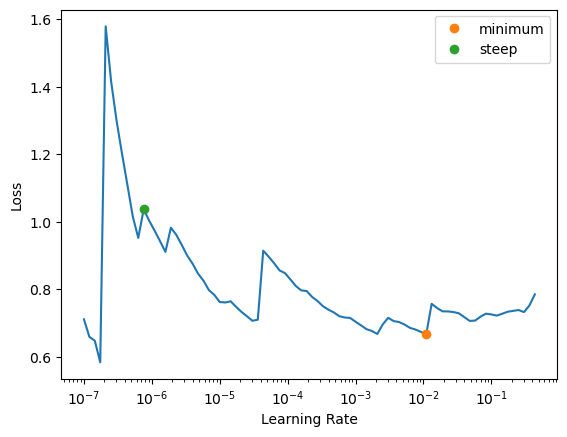

In [304]:
if trainNewModel:
    learn = tabular_learner(dls, metrics=[rmse, mae])

    # Learning rate finder
    lr_min, lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

    # Check if learning rates are valid
    if lr_min is None or lr_steep is None:
        raise ValueError("Learning rate finder did not return valid learning rates.")

    # Train
    print(f"Training for {epochs} epochs...")
    learn.fit_one_cycle(epochs, lr_max=lr_steep)
    print("Model training complete")

    learn.export(modelFolder / f'{modelName}.pkl')

## Testing and benchmarking

$FCLF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FCLF: No historical data available for FCLF around 2024-01-27.
Error fetching data for PF: No historical data available for PF around 2024-01-27.


$AGU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$NTT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$LLTC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AGU: No historical data available for AGU around 2024-01-27.
Error fetching data for NTT: No historical data available for NTT around 2024-01-27.
Error fetching data for LLTC: No historical data available for LLTC around 2024-01-27.


$MJN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MJN: No historical data available for MJN around 2024-01-27.


$INSY: possibly delisted; no timezone found


Error fetching data for INSY: No historical data available for INSY around 2024-01-27.


$PPR: possibly delisted; no timezone found
$KEYN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PPR: No historical data available for PPR around 2024-01-27.
Error fetching data for KEYN: No historical data available for KEYN around 2024-01-27.


$RBS-I: possibly delisted; no timezone found
$SLTC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$EXA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for RBS-I: No historical data available for RBS-I around 2024-01-27.
Error fetching data for SLTC: No historical data available for SLTC around 2024-01-27.
Error fetching data for EXA: No historical data available for EXA around 2024-01-27.


$NNC-F: possibly delisted; no timezone found


Error fetching data for NNC-F: No historical data available for NNC-F around 2024-01-27.


$PGH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PGH: No historical data available for PGH around 2024-01-27.


$ANDAW: possibly delisted; no timezone found
$HAST: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ANDAW: No historical data available for ANDAW around 2024-01-27.
Error fetching data for HAST: No historical data available for HAST around 2024-01-27.


$SRT: possibly delisted; no timezone found
$CUBIL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SRT: No historical data available for SRT around 2024-01-27.
Error fetching data for CUBIL: No historical data available for CUBIL around 2024-01-27.


$LUB: possibly delisted; no timezone found
$FSYS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$BGSC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LUB: No historical data available for LUB around 2024-01-27.
Error fetching data for FSYS: No historical data available for FSYS around 2024-01-27.
Error fetching data for BGSC: No historical data available for BGSC around 2024-01-27.


$MXIM: possibly delisted; no timezone found


Error fetching data for MXIM: No historical data available for MXIM around 2024-01-27.


$MSG: possibly delisted; no timezone found


Error fetching data for MSG: No historical data available for MSG around 2024-01-27.


$USB-A: possibly delisted; no timezone found


Error fetching data for USB-A: No historical data available for USB-A around 2024-01-27.


$AMTG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AMTG: No historical data available for AMTG around 2024-01-27.


$SWU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$ACAS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$APSA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SWU: No historical data available for SWU around 2024-01-27.
Error fetching data for ACAS: No historical data available for ACAS around 2024-01-27.
Error fetching data for APSA: No historical data available for APSA around 2024-01-27.


$WAIR: possibly delisted; no timezone found
$ASDR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$XOOM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for WAIR: No historical data available for WAIR around 2024-01-27.
Error fetching data for ASDR: No historical data available for ASDR around 2024-01-27.
Error fetching data for XOOM: No historical data available for XOOM around 2024-01-27.


$IMRS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IMRS: No historical data available for IMRS around 2024-01-27.


$UNT: possibly delisted; no timezone found


Error fetching data for UNT: No historical data available for UNT around 2024-01-27.


$PTRY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PTRY: No historical data available for PTRY around 2024-01-27.


$NXR: possibly delisted; no timezone found


Error fetching data for NXR: No historical data available for NXR around 2024-01-27.


$SNI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SNI: No historical data available for SNI around 2024-01-27.


$ZB-G: possibly delisted; no timezone found


Error fetching data for ZB-G: No historical data available for ZB-G around 2024-01-27.


$TSC: possibly delisted; no timezone found
$PENX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TSC: No historical data available for TSC around 2024-01-27.
Error fetching data for PENX: No historical data available for PENX around 2024-01-27.


$MFNC: possibly delisted; no timezone found
$RNO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MFNC: No historical data available for MFNC around 2024-01-27.
Error fetching data for RNO: No historical data available for RNO around 2024-01-27.


$AFW: possibly delisted; no timezone found


Error fetching data for AFW: No historical data available for AFW around 2024-01-27.


$BEE-C: possibly delisted; no timezone found


Error fetching data for BEE-C: No historical data available for BEE-C around 2024-01-27.


$MFRI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MFRI: No historical data available for MFRI around 2024-01-27.


$CYNO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CYNO: No historical data available for CYNO around 2024-01-27.


$NFX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NFX: No historical data available for NFX around 2024-01-27.


$KRFT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for KRFT: No historical data available for KRFT around 2024-01-27.


$KYN-F: possibly delisted; no timezone found


Error fetching data for KYN-F: No historical data available for KYN-F around 2024-01-27.


$BBNK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BBNK: No historical data available for BBNK around 2024-01-27.


$NLSN: possibly delisted; no timezone found
$VRNG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NLSN: No historical data available for NLSN around 2024-01-27.
Error fetching data for VRNG: No historical data available for VRNG around 2024-01-27.


$MER-P: possibly delisted; no timezone found


Error fetching data for MER-P: No historical data available for MER-P around 2024-01-27.


$FLY: possibly delisted; no timezone found


Error fetching data for FLY: No historical data available for FLY around 2024-01-27.


$HT: possibly delisted; no timezone found


Error fetching data for HT: No historical data available for HT around 2024-01-27.


$PCTI: possibly delisted; no timezone found


Error fetching data for PCTI: No historical data available for PCTI around 2024-01-27.


$C-Q: possibly delisted; no timezone found


Error fetching data for C-Q: No historical data available for C-Q around 2024-01-27.


$UCBI: possibly delisted; no timezone found


Error fetching data for UCBI: No historical data available for UCBI around 2024-01-27.


$SJR: possibly delisted; no timezone found


Error fetching data for SJR: No historical data available for SJR around 2024-01-27.


$DRYS: possibly delisted; no timezone found


Error fetching data for DRYS: No historical data available for DRYS around 2024-01-27.


$BKEPP: possibly delisted; no timezone found


Error fetching data for BKEPP: No historical data available for BKEPP around 2024-01-27.


$OFG-D: possibly delisted; no timezone found


Error fetching data for OFG-D: No historical data available for OFG-D around 2024-01-27.


$NZH-A: possibly delisted; no timezone found


Error fetching data for NZH-A: No historical data available for NZH-A around 2024-01-27.


$REN.W: possibly delisted; no timezone found


Error fetching data for REN.W: No historical data available for REN.W around 2024-01-27.


$SAN-E: possibly delisted; no timezone found
$AFOP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SAN-E: No historical data available for SAN-E around 2024-01-27.
Error fetching data for AFOP: No historical data available for AFOP around 2024-01-27.


$YHOO: possibly delisted; no timezone found
$LUK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$GCA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for YHOO: No historical data available for YHOO around 2024-01-27.
Error fetching data for LUK: No historical data available for LUK around 2024-01-27.
Error fetching data for GCA: No historical data available for GCA around 2024-01-27.


$ENDP: possibly delisted; no timezone found
$CVO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$KIPS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ENDP: No historical data available for ENDP around 2024-01-27.
Error fetching data for CVO: No historical data available for CVO around 2024-01-27.
Error fetching data for KIPS: No historical data available for KIPS around 2024-01-27.


$NRZ: possibly delisted; no timezone found


Error fetching data for NRZ: No historical data available for NRZ around 2024-01-27.


$KRC-H: possibly delisted; no timezone found


Error fetching data for KRC-H: No historical data available for KRC-H around 2024-01-27.


$EMZ: possibly delisted; no timezone found
$OEH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$ADRU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EMZ: No historical data available for EMZ around 2024-01-27.
Error fetching data for OEH: No historical data available for OEH around 2024-01-27.
Error fetching data for ADRU: No historical data available for ADRU around 2024-01-27.


$CBAK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CBAK: No historical data available for CBAK around 2024-01-27.


$MER-K: possibly delisted; no timezone found
$ATMI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MER-K: No historical data available for MER-K around 2024-01-27.
Error fetching data for ATMI: No historical data available for ATMI around 2024-01-27.


$RBS-M: possibly delisted; no timezone found


Error fetching data for RBS-M: No historical data available for RBS-M around 2024-01-27.


$MYJ: possibly delisted; no timezone found


Error fetching data for MYJ: No historical data available for MYJ around 2024-01-27.


$CREE: possibly delisted; no timezone found


Error fetching data for CREE: No historical data available for CREE around 2024-01-27.


$STI-E: possibly delisted; no timezone found


Error fetching data for STI-E: No historical data available for STI-E around 2024-01-27.


$CRMB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CRMB: No historical data available for CRMB around 2024-01-27.


$GLUU: possibly delisted; no timezone found
$HPOL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GLUU: No historical data available for GLUU around 2024-01-27.
Error fetching data for HPOL: No historical data available for HPOL around 2024-01-27.


$CCCR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$CBST: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CCCR: No historical data available for CCCR around 2024-01-27.
Error fetching data for CBST: No historical data available for CBST around 2024-01-27.


$DXM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DXM: No historical data available for DXM around 2024-01-27.


$GTAT: possibly delisted; no timezone found


Error fetching data for GTAT: No historical data available for GTAT around 2024-01-27.


$CMN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CMN: No historical data available for CMN around 2024-01-27.


$HTF: possibly delisted; no timezone found
$NMRX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$BPO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HTF: No historical data available for HTF around 2024-01-27.
Error fetching data for NMRX: No historical data available for NMRX around 2024-01-27.
Error fetching data for BPO: No historical data available for BPO around 2024-01-27.


$GRT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$EGN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GRT: No historical data available for GRT around 2024-01-27.
Error fetching data for EGN: No historical data available for EGN around 2024-01-27.


$JGV: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for JGV: No historical data available for JGV around 2024-01-27.


$RVLT: possibly delisted; no timezone found


Error fetching data for RVLT: No historical data available for RVLT around 2024-01-27.


$PPO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PPO: No historical data available for PPO around 2024-01-27.


$ALXA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$CHTP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ALXA: No historical data available for ALXA around 2024-01-27.
Error fetching data for CHTP: No historical data available for CHTP around 2024-01-27.


$ESBF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$EAA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ESBF: No historical data available for ESBF around 2024-01-27.
Error fetching data for EAA: No historical data available for EAA around 2024-01-27.


$WLBPZ: possibly delisted; no timezone found
$LXK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$IM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for WLBPZ: No historical data available for WLBPZ around 2024-01-27.
Error fetching data for LXK: No historical data available for LXK around 2024-01-27.
Error fetching data for IM: No historical data available for IM around 2024-01-27.


$BKYF: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PVR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BKYF: No historical data available for BKYF around 2024-01-27.
Error fetching data for PVR: No historical data available for PVR around 2024-01-27.


$TWX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$AXJS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TWX: No historical data available for TWX around 2024-01-27.
Error fetching data for AXJS: No historical data available for AXJS around 2024-01-27.


$BPHX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BPHX: No historical data available for BPHX around 2024-01-27.


$ELS-C: possibly delisted; no timezone found


Error fetching data for ELS-C: No historical data available for ELS-C around 2024-01-27.


$WMGI: possibly delisted; no timezone found


Error fetching data for WMGI: No historical data available for WMGI around 2024-01-27.


$JRCC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$PPHM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for JRCC: No historical data available for JRCC around 2024-01-27.
Error fetching data for PPHM: No historical data available for PPHM around 2024-01-27.


$CISAA: possibly delisted; no timezone found


Error fetching data for CISAA: No historical data available for CISAA around 2024-01-27.


$PKI: possibly delisted; no timezone found


Error fetching data for PKI: No historical data available for PKI around 2024-01-27.


$RPRXW: possibly delisted; no timezone found


Error fetching data for RPRXW: No historical data available for RPRXW around 2024-01-27.


$GNC: possibly delisted; no timezone found


Error fetching data for GNC: No historical data available for GNC around 2024-01-27.


$ROVI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ROVI: No historical data available for ROVI around 2024-01-27.


$MTSN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$DFZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MTSN: No historical data available for MTSN around 2024-01-27.
Error fetching data for DFZ: No historical data available for DFZ around 2024-01-27.


$RBS: possibly delisted; no timezone found


Error fetching data for RBS: No historical data available for RBS around 2024-01-27.


$UEPS: possibly delisted; no timezone found
$FCVA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for UEPS: No historical data available for UEPS around 2024-01-27.
Error fetching data for FCVA: No historical data available for FCVA around 2024-01-27.


$AMCN: possibly delisted; no timezone found


Error fetching data for AMCN: No historical data available for AMCN around 2024-01-27.


$IFNA: possibly delisted; no timezone found


Error fetching data for IFNA: No historical data available for IFNA around 2024-01-27.


$ROLL: possibly delisted; no timezone found


Error fetching data for ROLL: No historical data available for ROLL around 2024-01-27.


$JMPB: possibly delisted; no timezone found


Error fetching data for JMPB: No historical data available for JMPB around 2024-01-27.


$DNY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DNY: No historical data available for DNY around 2024-01-27.


$DRU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$ROCM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$KAP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DRU: No historical data available for DRU around 2024-01-27.
Error fetching data for ROCM: No historical data available for ROCM around 2024-01-27.
Error fetching data for KAP: No historical data available for KAP around 2024-01-27.


$LABC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$AMRS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LABC: No historical data available for LABC around 2024-01-27.
Error fetching data for AMRS: No historical data available for AMRS around 2024-01-27.


$DX-B: possibly delisted; no timezone found
$PMC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DX-B: No historical data available for DX-B around 2024-01-27.
Error fetching data for PMC: No historical data available for PMC around 2024-01-27.


$SKH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SKH: No historical data available for SKH around 2024-01-27.


$UTX-A: possibly delisted; no timezone found


Error fetching data for UTX-A: No historical data available for UTX-A around 2024-01-27.


$DPM: possibly delisted; no timezone found


Error fetching data for DPM: No historical data available for DPM around 2024-01-27.


$NVY-C: possibly delisted; no timezone found


Error fetching data for NVY-C: No historical data available for NVY-C around 2024-01-27.


$ISS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ISS: No historical data available for ISS around 2024-01-27.


$GOM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GOM: No historical data available for GOM around 2024-01-27.


$HOS: possibly delisted; no timezone found


Error fetching data for HOS: No historical data available for HOS around 2024-01-27.


$SGYPW: possibly delisted; no timezone found


Error fetching data for SGYPW: No historical data available for SGYPW around 2024-01-27.


$IDRA: possibly delisted; no timezone found


Error fetching data for IDRA: No historical data available for IDRA around 2024-01-27.


$HMSY: possibly delisted; no timezone found


Error fetching data for HMSY: No historical data available for HMSY around 2024-01-27.


$GDV-A: possibly delisted; no timezone found
$ABFS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GDV-A: No historical data available for GDV-A around 2024-01-27.
Error fetching data for ABFS: No historical data available for ABFS around 2024-01-27.


$HOT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$MDCI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HOT: No historical data available for HOT around 2024-01-27.
Error fetching data for MDCI: No historical data available for MDCI around 2024-01-27.


$AT: possibly delisted; no timezone found
$NDZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AT: No historical data available for AT around 2024-01-27.
Error fetching data for NDZ: No historical data available for NDZ around 2024-01-27.


$AVV: possibly delisted; no timezone found


Error fetching data for AVV: No historical data available for AVV around 2024-01-27.


$CQB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CQB: No historical data available for CQB around 2024-01-27.


$DNI: possibly delisted; no timezone found


Error fetching data for DNI: No historical data available for DNI around 2024-01-27.


$MBRG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MBRG: No historical data available for MBRG around 2024-01-27.


$ATRI: possibly delisted; no timezone found
$FSCE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ATRI: No historical data available for ATRI around 2024-01-27.
Error fetching data for FSCE: No historical data available for FSCE around 2024-01-27.


$PCMI: possibly delisted; no timezone found
$JACQW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PCMI: No historical data available for PCMI around 2024-01-27.
Error fetching data for JACQW: No historical data available for JACQW around 2024-01-27.


$SBSA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SBSA: No historical data available for SBSA around 2024-01-27.


$BIRT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$HSP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BIRT: No historical data available for BIRT around 2024-01-27.
Error fetching data for HSP: No historical data available for HSP around 2024-01-27.


$CTQ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$XNY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$HOTR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CTQ: No historical data available for CTQ around 2024-01-27.
Error fetching data for XNY: No historical data available for XNY around 2024-01-27.
Error fetching data for HOTR: No historical data available for HOTR around 2024-01-27.


$PACR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PACR: No historical data available for PACR around 2024-01-27.


$PRE-D: possibly delisted; no timezone found


Error fetching data for PRE-D: No historical data available for PRE-D around 2024-01-27.


$PWX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PWX: No historical data available for PWX around 2024-01-27.


$GXP-A: possibly delisted; no timezone found


Error fetching data for GXP-A: No historical data available for GXP-A around 2024-01-27.


$AES-PC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AES-PC: No historical data available for AES-PC around 2024-01-27.


$CEMI: possibly delisted; no timezone found
$DBLEP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CEMI: No historical data available for CEMI around 2024-01-27.
Error fetching data for DBLEP: No historical data available for DBLEP around 2024-01-27.


$CLR: possibly delisted; no timezone found


Error fetching data for CLR: No historical data available for CLR around 2024-01-27.


$FEFN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FEFN: No historical data available for FEFN around 2024-01-27.


$ZIXI: possibly delisted; no timezone found


Error fetching data for ZIXI: No historical data available for ZIXI around 2024-01-27.


$CPSL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")
$FULL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CPSL: No historical data available for CPSL around 2024-01-27.
Error fetching data for FULL: No historical data available for FULL around 2024-01-27.


$PKH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PKH: No historical data available for PKH around 2024-01-27.


$PCBK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$JDSU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PCBK: No historical data available for PCBK around 2024-01-27.
Error fetching data for JDSU: No historical data available for JDSU around 2024-01-27.


$SPLK: possibly delisted; no timezone found
$XKO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SPLK: No historical data available for SPLK around 2024-01-27.
Error fetching data for XKO: No historical data available for XKO around 2024-01-27.


$MW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$SLTM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MW: No historical data available for MW around 2024-01-27.
Error fetching data for SLTM: No historical data available for SLTM around 2024-01-27.


$NXQ: possibly delisted; no timezone found


Error fetching data for NXQ: No historical data available for NXQ around 2024-01-27.


$MBVT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MBVT: No historical data available for MBVT around 2024-01-27.


$PKY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$TECUA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$TLM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PKY: No historical data available for PKY around 2024-01-27.
Error fetching data for TECUA: No historical data available for TECUA around 2024-01-27.
Error fetching data for TLM: No historical data available for TLM around 2024-01-27.


$GAB-D: possibly delisted; no timezone found


Error fetching data for GAB-D: No historical data available for GAB-D around 2024-01-27.


$MRTX: possibly delisted; no timezone found


Error fetching data for MRTX: No historical data available for MRTX around 2024-01-27.


$CNAT: possibly delisted; no timezone found
$APRI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CNAT: No historical data available for CNAT around 2024-01-27.
Error fetching data for APRI: No historical data available for APRI around 2024-01-27.


$MAMS: possibly delisted; no timezone found


Error fetching data for MAMS: No historical data available for MAMS around 2024-01-27.


$CARB: possibly delisted; no timezone found


Error fetching data for CARB: No historical data available for CARB around 2024-01-27.


$NNA: possibly delisted; no timezone found


Error fetching data for NNA: No historical data available for NNA around 2024-01-27.


$TKMR: possibly delisted; no timezone found


Error fetching data for TKMR: No historical data available for TKMR around 2024-01-27.


$ELNK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ELNK: No historical data available for ELNK around 2024-01-27.


$SNSS: possibly delisted; no timezone found


Error fetching data for SNSS: No historical data available for SNSS around 2024-01-27.


$GXP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GXP: No historical data available for GXP around 2024-01-27.


$VAR: possibly delisted; no timezone found


Error fetching data for VAR: No historical data available for VAR around 2024-01-27.


$AMRB: possibly delisted; no timezone found


Error fetching data for AMRB: No historical data available for AMRB around 2024-01-27.


$CTCM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CTCM: No historical data available for CTCM around 2024-01-27.


$CCCL: possibly delisted; no timezone found


Error fetching data for CCCL: No historical data available for CCCL around 2024-01-27.


$LVNTA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$TELK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LVNTA: No historical data available for LVNTA around 2024-01-27.
Error fetching data for TELK: No historical data available for TELK around 2024-01-27.


$CXDC: possibly delisted; no timezone found


Error fetching data for CXDC: No historical data available for CXDC around 2024-01-27.


$PNTR: possibly delisted; no timezone found
$TSO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PNTR: No historical data available for PNTR around 2024-01-27.
Error fetching data for TSO: No historical data available for TSO around 2024-01-27.


$CRRC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CRRC: No historical data available for CRRC around 2024-01-27.


$AAN: possibly delisted; no timezone found
$FPO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AAN: No historical data available for AAN around 2024-01-27.
Error fetching data for FPO: No historical data available for FPO around 2024-01-27.


$TXCC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TXCC: No historical data available for TXCC around 2024-01-27.


$OSHC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for OSHC: No historical data available for OSHC around 2024-01-27.


$NTX-C: possibly delisted; no timezone found


Error fetching data for NTX-C: No historical data available for NTX-C around 2024-01-27.


$FCCY: possibly delisted; no timezone found


Error fetching data for FCCY: No historical data available for FCCY around 2024-01-27.


$CSRE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CSRE: No historical data available for CSRE around 2024-01-27.


$NWY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$ISH: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for NWY: No historical data available for NWY around 2024-01-27.
Error fetching data for ISH: No historical data available for ISH around 2024-01-27.


$ACPW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$EDT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ACPW: No historical data available for ACPW around 2024-01-27.
Error fetching data for EDT: No historical data available for EDT around 2024-01-27.


$STJ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for STJ: No historical data available for STJ around 2024-01-27.


$CVTI: possibly delisted; no timezone found


Error fetching data for CVTI: No historical data available for CVTI around 2024-01-27.


$KIM-J: possibly delisted; no timezone found


Error fetching data for KIM-J: No historical data available for KIM-J around 2024-01-27.


$HTGZ: possibly delisted; no timezone found


Error fetching data for HTGZ: No historical data available for HTGZ around 2024-01-27.


$GTXI: possibly delisted; no timezone found


Error fetching data for GTXI: No historical data available for GTXI around 2024-01-27.


$TESS: possibly delisted; no timezone found
$UTIW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TESS: No historical data available for TESS around 2024-01-27.
Error fetching data for UTIW: No historical data available for UTIW around 2024-01-27.


$TNAV: possibly delisted; no timezone found
$CTC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TNAV: No historical data available for TNAV around 2024-01-27.
Error fetching data for CTC: No historical data available for CTC around 2024-01-27.


$PSB-R: possibly delisted; no timezone found


Error fetching data for PSB-R: No historical data available for PSB-R around 2024-01-27.


$SSW-C: possibly delisted; no timezone found


Error fetching data for SSW-C: No historical data available for SSW-C around 2024-01-27.


$PEIX: possibly delisted; no timezone found


Error fetching data for PEIX: No historical data available for PEIX around 2024-01-27.


$MANT: possibly delisted; no timezone found
$PUK.P: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MANT: No historical data available for MANT around 2024-01-27.
Error fetching data for PUK.P: No historical data available for PUK.P around 2024-01-27.


$SAI: possibly delisted; no timezone found


Error fetching data for SAI: No historical data available for SAI around 2024-01-27.


$AVID: possibly delisted; no timezone found
$BMC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AVID: No historical data available for AVID around 2024-01-27.
Error fetching data for BMC: No historical data available for BMC around 2024-01-27.


$NNC-E: possibly delisted; no timezone found


Error fetching data for NNC-E: No historical data available for NNC-E around 2024-01-27.


$LPDX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$MPEL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LPDX: No historical data available for LPDX around 2024-01-27.
Error fetching data for MPEL: No historical data available for MPEL around 2024-01-27.


$GFY: possibly delisted; no timezone found


Error fetching data for GFY: No historical data available for GFY around 2024-01-27.


$PSA-P: possibly delisted; no timezone found


Error fetching data for PSA-P: No historical data available for PSA-P around 2024-01-27.


$SAL: possibly delisted; no timezone found


Error fetching data for SAL: No historical data available for SAL around 2024-01-27.


$LNDC: possibly delisted; no timezone found


Error fetching data for LNDC: No historical data available for LNDC around 2024-01-27.


$SPHS: possibly delisted; no timezone found
$OPTR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SPHS: No historical data available for SPHS around 2024-01-27.
Error fetching data for OPTR: No historical data available for OPTR around 2024-01-27.


$NCU-C: possibly delisted; no timezone found


Error fetching data for NCU-C: No historical data available for NCU-C around 2024-01-27.


$MOCO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MOCO: No historical data available for MOCO around 2024-01-27.


$BTUI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BTUI: No historical data available for BTUI around 2024-01-27.


$SEAS: possibly delisted; no timezone found


Error fetching data for SEAS: No historical data available for SEAS around 2024-01-27.


$MTSL: possibly delisted; no timezone found


Error fetching data for MTSL: No historical data available for MTSL around 2024-01-27.


$MSZ: possibly delisted; no timezone found


Error fetching data for MSZ: No historical data available for MSZ around 2024-01-27.


$IRE-B: possibly delisted; no timezone found


Error fetching data for IRE-B: No historical data available for IRE-B around 2024-01-27.


$BRE-D: possibly delisted; no timezone found
$JPZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BRE-D: No historical data available for BRE-D around 2024-01-27.
Error fetching data for JPZ: No historical data available for JPZ around 2024-01-27.


$FFBCW: possibly delisted; no timezone found


Error fetching data for FFBCW: No historical data available for FFBCW around 2024-01-27.


$GAM-B: possibly delisted; no timezone found
$QCOR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GAM-B: No historical data available for GAM-B around 2024-01-27.
Error fetching data for QCOR: No historical data available for QCOR around 2024-01-27.


$AOI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for AOI: No historical data available for AOI around 2024-01-27.


$FFNM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FFNM: No historical data available for FFNM around 2024-01-27.


$HMIN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HMIN: No historical data available for HMIN around 2024-01-27.


$COR-A: possibly delisted; no timezone found


Error fetching data for COR-A: No historical data available for COR-A around 2024-01-27.


$BSTC: possibly delisted; no timezone found
$PCLN: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for BSTC: No historical data available for BSTC around 2024-01-27.
Error fetching data for PCLN: No historical data available for PCLN around 2024-01-27.


$MKC.V: possibly delisted; no timezone found
$UAM: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MKC.V: No historical data available for MKC.V around 2024-01-27.
Error fetching data for UAM: No historical data available for UAM around 2024-01-27.


$SBW: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SBW: No historical data available for SBW around 2024-01-27.


$FDI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$ONVI: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FDI: No historical data available for FDI around 2024-01-27.
Error fetching data for ONVI: No historical data available for ONVI around 2024-01-27.


$BSE: possibly delisted; no timezone found


Error fetching data for BSE: No historical data available for BSE around 2024-01-27.


$CTRL: possibly delisted; no timezone found


Error fetching data for CTRL: No historical data available for CTRL around 2024-01-27.


$CSU: possibly delisted; no timezone found


Error fetching data for CSU: No historical data available for CSU around 2024-01-27.


$PBIP: possibly delisted; no timezone found
$CRDC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PBIP: No historical data available for PBIP around 2024-01-27.
Error fetching data for CRDC: No historical data available for CRDC around 2024-01-27.


$BEE-B: possibly delisted; no timezone found


Error fetching data for BEE-B: No historical data available for BEE-B around 2024-01-27.


$KIM-H: possibly delisted; no timezone found


Error fetching data for KIM-H: No historical data available for KIM-H around 2024-01-27.


$EBSB: possibly delisted; no timezone found


Error fetching data for EBSB: No historical data available for EBSB around 2024-01-27.


$BML-H: possibly delisted; no timezone found


Error fetching data for BML-H: No historical data available for BML-H around 2024-01-27.


$KRA: possibly delisted; no timezone found


Error fetching data for KRA: No historical data available for KRA around 2024-01-27.


$RAVN: possibly delisted; no timezone found


Error fetching data for RAVN: No historical data available for RAVN around 2024-01-27.


$EPR-F: possibly delisted; no timezone found
$JACQU: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EPR-F: No historical data available for EPR-F around 2024-01-27.
Error fetching data for JACQU: No historical data available for JACQU around 2024-01-27.


$IDT.P: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IDT.P: No historical data available for IDT.P around 2024-01-27.


$JADE: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for JADE: No historical data available for JADE around 2024-01-27.


$NZH-B: possibly delisted; no timezone found


Error fetching data for NZH-B: No historical data available for NZH-B around 2024-01-27.


$MILL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$OCZ: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MILL: No historical data available for MILL around 2024-01-27.
Error fetching data for OCZ: No historical data available for OCZ around 2024-01-27.


$TMK: possibly delisted; no timezone found


Error fetching data for TMK: No historical data available for TMK around 2024-01-27.


$JMT: possibly delisted; no timezone found


Error fetching data for JMT: No historical data available for JMT around 2024-01-27.


$DRTX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for DRTX: No historical data available for DRTX around 2024-01-27.


$HMTV: possibly delisted; no timezone found
$PMFG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HMTV: No historical data available for HMTV around 2024-01-27.
Error fetching data for PMFG: No historical data available for PMFG around 2024-01-27.


$FFCO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$STO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FFCO: No historical data available for FFCO around 2024-01-27.
Error fetching data for STO: No historical data available for STO around 2024-01-27.


$BCS-D: possibly delisted; no timezone found


Error fetching data for BCS-D: No historical data available for BCS-D around 2024-01-27.


$FAC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for FAC: No historical data available for FAC around 2024-01-27.


$C-N: possibly delisted; no timezone found


Error fetching data for C-N: No historical data available for C-N around 2024-01-27.


$IRG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for IRG: No historical data available for IRG around 2024-01-27.


$BML-I: possibly delisted; no timezone found


Error fetching data for BML-I: No historical data available for BML-I around 2024-01-27.


$CS: possibly delisted; no timezone found
$CSG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CS: No historical data available for CS around 2024-01-27.
Error fetching data for CSG: No historical data available for CSG around 2024-01-27.


$LLL: possibly delisted; no timezone found
$MTB.P: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for LLL: No historical data available for LLL around 2024-01-27.
Error fetching data for MTB.P: No historical data available for MTB.P around 2024-01-27.


$STI-A: possibly delisted; no timezone found


Error fetching data for STI-A: No historical data available for STI-A around 2024-01-27.


$HFC: possibly delisted; no timezone found
$CCSC: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for HFC: No historical data available for HFC around 2024-01-27.
Error fetching data for CCSC: No historical data available for CCSC around 2024-01-27.


$XPLR: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$HGT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$BSP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for XPLR: No historical data available for XPLR around 2024-01-27.
Error fetching data for HGT: No historical data available for HGT around 2024-01-27.
Error fetching data for BSP: No historical data available for BSP around 2024-01-27.


$PZB: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PZB: No historical data available for PZB around 2024-01-27.


$BKCC: possibly delisted; no timezone found


Error fetching data for BKCC: No historical data available for BKCC around 2024-01-27.


$GPM: possibly delisted; no timezone found


Error fetching data for GPM: No historical data available for GPM around 2024-01-27.


$ZNGA: possibly delisted; no timezone found


Error fetching data for ZNGA: No historical data available for ZNGA around 2024-01-27.


$PSB-V: possibly delisted; no timezone found
$MELA: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for PSB-V: No historical data available for PSB-V around 2024-01-27.
Error fetching data for MELA: No historical data available for MELA around 2024-01-27.


$MRH-A: possibly delisted; no timezone found


Error fetching data for MRH-A: No historical data available for MRH-A around 2024-01-27.


$DX-A: possibly delisted; no timezone found


Error fetching data for DX-A: No historical data available for DX-A around 2024-01-27.


$EMES: possibly delisted; no timezone found
$FCY: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for EMES: No historical data available for EMES around 2024-01-27.
Error fetching data for FCY: No historical data available for FCY around 2024-01-27.
Error fetching data for DMO: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SGF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for CXE: Too Many Requests. Rate limited. Try after a while.
Error fetching data for ACOR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SID: Too Many Requests. Rate limited. Try after a while.
Error fetching data for OKSBP: Too Many Requests. Rate limited. Try after a while.
Error fetching data for KR: Too Many Requests. Rate limited. Try after a while.
Error fetching data for EGF: Too Many Requests. Rate limited. Try after a while.
Error fetching data for SNDK: Too Many Requests. Rate limited. Try after a while.
Error fetching data for LCC: Too Many Requests. Rate limited. Try after a while.
Error fetching 

$ABMD: possibly delisted; no timezone found
$PEOP: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for ABMD: No historical data available for ABMD around 2024-01-27.
Error fetching data for PEOP: No historical data available for PEOP around 2024-01-27.


$CPE: possibly delisted; no timezone found
$SYUT: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for CPE: No historical data available for CPE around 2024-01-27.
Error fetching data for SYUT: No historical data available for SYUT around 2024-01-27.


$TI: possibly delisted; no timezone found
$RIMG: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for TI: No historical data available for TI around 2024-01-27.
Error fetching data for RIMG: No historical data available for RIMG around 2024-01-27.


$CNL: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27) (Yahoo error = "Data doesn't exist for startDate = 1703739600, endDate = 1706331600")


Error fetching data for CNL: No historical data available for CNL around 2024-01-27.


$PSA-X: possibly delisted; no timezone found


Error fetching data for PSA-X: No historical data available for PSA-X around 2024-01-27.


$NRF-C: possibly delisted; no timezone found


Error fetching data for NRF-C: No historical data available for NRF-C around 2024-01-27.


$UBA: possibly delisted; no timezone found


Error fetching data for UBA: No historical data available for UBA around 2024-01-27.


$RRD: possibly delisted; no timezone found


Error fetching data for RRD: No historical data available for RRD around 2024-01-27.


$DCUA: possibly delisted; no timezone found


Error fetching data for DCUA: No historical data available for DCUA around 2024-01-27.


$VLYWW: possibly delisted; no timezone found
$ARO: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for VLYWW: No historical data available for VLYWW around 2024-01-27.
Error fetching data for ARO: No historical data available for ARO around 2024-01-27.


$SCHN: possibly delisted; no timezone found
$LBIX: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)
$SCSS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for SCHN: No historical data available for SCHN around 2024-01-27.
Error fetching data for LBIX: No historical data available for LBIX around 2024-01-27.
Error fetching data for SCSS: No historical data available for SCSS around 2024-01-27.


$MBIS: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for MBIS: No historical data available for MBIS around 2024-01-27.


$GTIV: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for GTIV: No historical data available for GTIV around 2024-01-27.


$QLIK: possibly delisted; no price data found  (1d 2023-12-28 -> 2024-01-27)


Error fetching data for QLIK: No historical data available for QLIK around 2024-01-27.


Logged evaluation results to /Users/victor/Documents/GitHub/VS-Code/Side-Projects/TrainedModels/stockScreener/modelEvaluations.csv


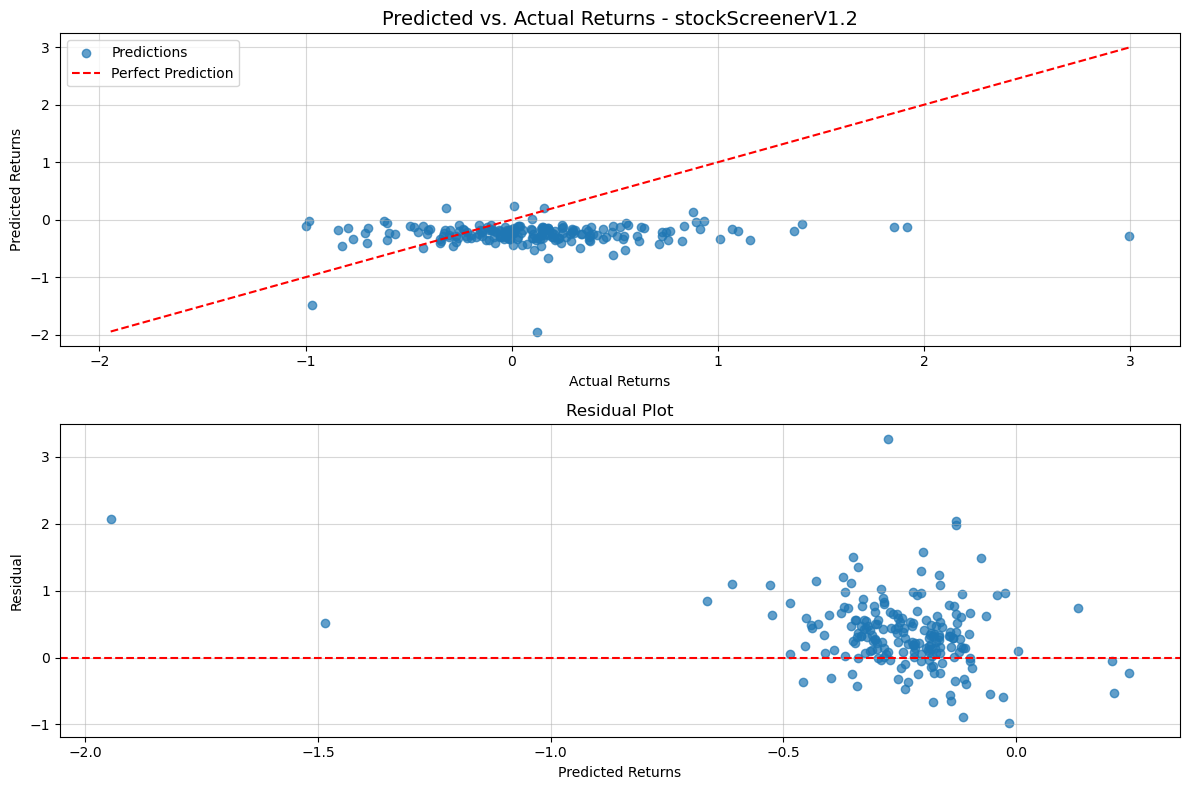

Collected 200 valid test tickers (target: 200)

Evaluation Results:
MAE: 0.477
RMSE: 0.642
R²: -0.616


In [305]:
def logEvaluation(model_name, mae, rmse, r2, model_folder, test_tickers):
    """Log evaluation metrics to CSV file"""
    log_file = model_folder / "modelEvaluations.csv"
    
    new_entry_df = pd.DataFrame([{
        "Model Name": model_name,
        "Timestamp": datetime.now().strftime('%Y-%m-%d %H:%M'),
        "MAE": f'{mae:.3f}',
        "RMSE": f'{rmse:.3f}',
        "R2": f'{r2:.3f}',
        "Epochs": epochs,
        "Training Size": trainingSize,
        "Test Size": len(test_tickers),
        "Cat Names": catNames,
        "Cont Names": contNames,
    }])
    
    try:
        log_df = pd.read_csv(log_file)
        log_df = pd.concat([log_df, new_entry_df], ignore_index=True)
    except FileNotFoundError:
        log_df = new_entry_df
        
    log_df.to_csv(log_file, index=False)
    print(f"Logged evaluation results to {log_file}")

def plotResults(results_df, model_name, model_folder):
    """Create and save visualization plots using all data points."""
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.scatter(results_df['Actual'], results_df['Predicted'], alpha=0.7, label='Predictions')
    min_val = min(results_df['Actual'].min(), results_df['Predicted'].min())
    max_val = max(results_df['Actual'].max(), results_df['Predicted'].max())
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Perfect Prediction')
    plt.title(f'Predicted vs. Actual Returns - {model_name}', fontsize=14)
    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.legend()
    plt.grid(alpha=0.5)
    
    plt.subplot(2, 1, 2)
    plt.scatter(results_df['Predicted'], results_df['Residual'], alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Predicted Returns')
    plt.ylabel('Residual')
    plt.grid(alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def evaluateModel(learn, test_data, model_name, model_folder, cont_names, cat_names):
    """Evaluate model on pre-collected test data"""
    # Clean data
    test_data_clean = test_data.dropna(subset=['EV/EBIT', 'ROIC', 'Future Year Change'])
    
    if test_data_clean.empty:
        raise ValueError("No valid test data after cleaning NaN values")

    # Create test dataloader
    test_dl = learn.dls.test_dl(test_data_clean)
    preds, targs = learn.get_preds(dl=test_dl)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Predicted': preds.numpy().flatten(),
        'Actual': targs.numpy().flatten()
    })
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # Calculate metrics
    mae = np.mean(np.abs(results_df['Residual']))
    rmse = np.sqrt(np.mean(results_df['Residual']**2))
    r2 = 1 - (np.sum(results_df['Residual']**2) / np.sum((results_df['Actual'] - results_df['Actual'].mean())**2))

    # Log and plot
    logEvaluation(model_name, mae, rmse, r2, model_folder, test_data_clean['Ticker'].unique())
    plotResults(results_df, model_name, model_folder)
    
    return mae, rmse, r2

if trainNewModel:
    nonTrainingTickers = list(set(tickers) - set(trainingTickers))
    validTestData = []
    attempted_tickers = set()
    attempts = 0

    if testSize * 4 <= len(tickers):  
        max_attempts = testSize * 4 # Prevent infinite loops
    else:
        max_attempts = len(tickers)

    # Keep trying until we reach testSize or exhaust attempts
    while len(validTestData) < testSize and attempts < max_attempts:
        # Get a new ticker we haven't tried yet
        remaining_tickers = [t for t in nonTrainingTickers if t not in attempted_tickers]
        if not remaining_tickers:  # If all tried, reset attempted list
            attempted_tickers = set()
            remaining_tickers = nonTrainingTickers
            
        ticker = np.random.choice(remaining_tickers)
        attempted_tickers.add(ticker)
        attempts += 1

        # Fetch and validate data
        data = getTickerDataFrom1YrAgo(ticker)
        if not data.empty and not data[['EV/EBIT', 'ROIC']].isna().any().any():
            validTestData.append(data)

    if not validTestData:
        raise ValueError("No valid test data collected after multiple attempts")
        
    # Trim to exact testSize if we collected more
    validTestData = validTestData[:testSize]  
    combinedTestData = pd.concat(validTestData, ignore_index=True)

    # Run evaluation
    mae, rmse, r2 = evaluateModel(
        learn=learn,
        test_data=combinedTestData,
        model_name=modelName,
        model_folder=modelFolder,
        cont_names=contNames,
        cat_names=catNames
    )

    # Show collection stats
    print(f"Collected {len(validTestData)} valid test tickers (target: {testSize})")
    if attempts >= max_attempts:
        print(f"Warning: Reached max attempts ({max_attempts}). Some invalid tickers may remain.")  
    print(f"\nEvaluation Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

## Tests

In [306]:
print('Model files in modelFolder:')
for file in modelFolder.glob('*.pkl'):
    print(file.name)

Model files in modelFolder:
stockScreenerV1.2.pkl
stockScreenerV1.0.pkl
stockScreenerV1.1.pkl


In [307]:
evaluations = pd.read_csv(modelFolder / 'modelEvaluations.csv')
bestModel = evaluations.sort_values('MAE', ascending=True).iloc[0]
bestModel.head()

Model Name    stockScreenerV1.1
Timestamp      2025-01-26 11:53
MAE                       0.393
RMSE                       0.91
R2                       -2.938
Name: 1, dtype: object

### Load model

In [308]:
if os.name == 'nt':
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
else:
    pathlib.WindowsPath = pathlib.PosixPath

importedModel = Path(f"{bestModel['Model Name']}.pkl") # Change this if you want to try other models
learn = load_learner(modelFolder / importedModel)

## Predictions

In [309]:
if predictionTarget != 'None':
    if predictionTarget == 'ALL':
        predictionTickers = tickers
    elif predictionTarget.endswith('%'):
        percentage = float(predictionTarget.strip('%')) / 100
        num_tickers = int(len(tickers) * percentage)
        predictionTickers = np.random.choice(tickers, size=num_tickers, replace=False).tolist()
    else:
        predictionTickers = [predictionTarget]

    # Fetch data for prediction tickers
    dfPrediction = pd.concat([getTickerData(ticker) for ticker in predictionTickers], ignore_index=True)

    # Ensure dfPrediction is a DataFrame
    if isinstance(dfPrediction, dict):
        dfPrediction = pd.DataFrame([dfPrediction])

    # Create test dataloader
    dl = learn.dls.test_dl(dfPrediction)
    dfPrediction.head()

    # Make predictions
    prediction = learn.get_preds(dl=dl)
    adr_df = pd.read_csv(testFolder / 'tickers.csv')
    company_dict = dict(zip(adr_df['Ticker'], adr_df['Company']))

    if predictionTarget == 'ALL' or predictionTarget.endswith('%'):
        sorted_predictions = sorted(zip(predictionTickers, prediction[0]), key=lambda x: x[1], reverse=True)
        print(f"Got predictions for {len(sorted_predictions)} tickers, expected: {len(predictionTickers)}")
        print(f"Prediction for best performing tickers:")
        for symbol, pred in sorted_predictions:
            company_name = company_dict.get(symbol, 'Unknown')
            print(f"{symbol} ({company_name}): {pred[0].item() * 100:.2f}%")
    else:
        company_name = company_dict.get(predictionTarget, 'Unknown')
        print(f"Prediction for {predictionTarget} ({company_name}):")
        print(f"{prediction[0][0][0].item() * 100:.2f}%")
    print("Free money?!")

predictionTarget = '1%'

Prediction for NVO (Novo Nordisk A/S):
50.54%
Free money?!
